# Gene tree discordance analysis

### Preparation

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import linregress
from scipy.cluster.hierarchy import linkage

In [3]:
from skbio.tree import TreeNode
from skbio.stats.distance import DistanceMatrix
from skbio.stats.ordination import pcoa as PCoA

In [4]:
from sklearn.manifold import MDS

In [5]:
%matplotlib inline

### Metadata

In [6]:
meta = pd.read_table('metadata.tsv', index_col=0)
meta.head()

,Type,UniProt,Protein,Gene,Length,Presence,Taxa,Sites,Model,Best,RF,Quartet,Dimension,Function
#SampleID,,,,,,,,,,,,,,
p0000,gene,B3PLT3,Valine--tRNA ligase (EC 6.1.1.9) (Valyl-tRNA s...,oppF-valS,1631.0,10196.0,9985.0,24497.0,LG,FastTree,0.4707,0.7026,4.269,ligase activity
p0001,gene,A0A173SLF7,Elongation factor G,fusA_1,880.0,10318.0,10237.0,7579.0,LG,FastTree,0.5646,0.6587,2.687,NaN
p0002,gene,B1AI94,ATP-dependent zinc metalloprotease FtsH (EC 3....,ftsH,721.0,10270.0,10243.0,19600.0,LG,p12345,0.4646,0.7736,5.320,NaN
p0003,gene,A0A0T5XBS3,DNA-directed RNA polymerase subunit beta' (RNA...,rpoC,1652.0,10298.0,10249.0,27503.0,LG,FastTree,0.3637,0.8805,5.026,DNA binding
p0004,gene,P19486,Elongation factor 1-alpha (EF-1-alpha) (Elonga...,tuf,424.0,10188.0,10054.0,4455.0,LG,FastTree,0.6127,0.7411,2.308,NaN


### Quartet score vs RF distance and # taxa

In [7]:
mpl.rcParams['figure.figsize'] = (5, 5)

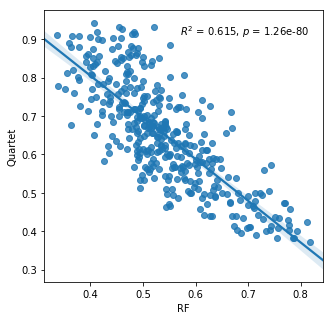

In [8]:
x, y = 'RF', 'Quartet'
df = meta[[x, y]].dropna()
reg = linregress(df.values)
ax = sns.regplot(x=x, y=y, data=df)
ax.text(0.95, 0.95,'$\itR^{2}$ = %.3f, $\it{p}$ = %.3g' % (reg.rvalue ** 2, reg.pvalue),
        horizontalalignment='right', verticalalignment='top', transform=ax.transAxes);

In [9]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('rf_vs_qt.pdf', bbox_to_inches='tight')

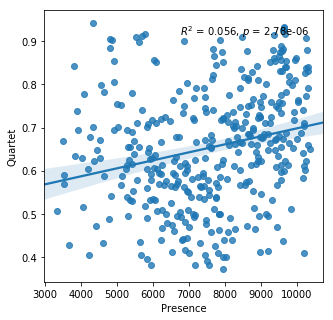

In [10]:
x, y = 'Presence', 'Quartet'
df = meta[[x, y]].dropna()
reg = linregress(df.values)
ax = sns.regplot(x=x, y=y, data=df)
ax.text(0.95, 0.95,'$\itR^{2}$ = %.3f, $\it{p}$ = %.3g' % (reg.rvalue ** 2, reg.pvalue),
        horizontalalignment='right', verticalalignment='top', transform=ax.transAxes);

In [11]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('qt_vs_pres.pdf', bbox_to_inches='tight')

### Read RF and QT distance matrics

In [12]:
with open('ids.txt', 'r') as f:
    ids = f.read().splitlines()

In [13]:
n = len(ids)
n

381

In [14]:
qtdm = DistanceMatrix.read('qts/qt.dm')
qtdm.shape

(382, 382)

In [15]:
rfdm = DistanceMatrix.read('rfd/rf.dm')
rfdm.shape

(382, 382)

In [16]:
ids += ['species']

### Hierarchical clustering

In [17]:
arr = qtdm.condensed_form()
lm = linkage(arr)
tree = TreeNode.from_linkage_matrix(lm, ids)
tree.write('qt.hclust.nwk')

'qt.hclust.nwk'

In [18]:
arr = rfdm.condensed_form()
lm = linkage(arr)
tree = TreeNode.from_linkage_matrix(lm, ids)
tree.write('rf.hclust.nwk')

'rf.hclust.nwk'

### PCoA using scikit-bio

In [19]:
pcoa = PCoA(qtdm)
pcoa.write('qt.pcoa.txt')

/Users/qiz173/anaconda/envs/py3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.8842325405223195 and the largest is 4.451868448813751.
  RuntimeWarning


'qt.pcoa.txt'

In [20]:
mpl.rcParams['figure.figsize'] = (9, 7)

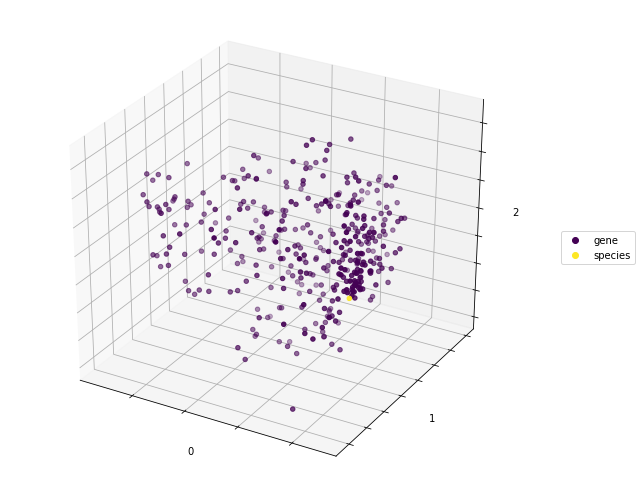

In [21]:
fig = pcoa.plot(df=meta, column='Type')

In [22]:
fig.savefig('qt.pcoa.type.pdf', bbox_to_inches='tight')

In [23]:
mpl.rcParams['figure.figsize'] = (11, 7)

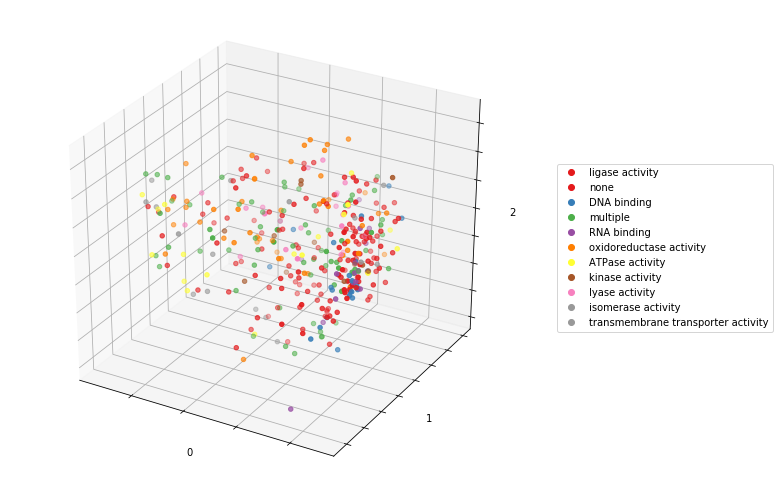

In [24]:
fig = pcoa.plot(df=meta[['Function']].fillna('none'), column='Function', cmap='Set1')

In [25]:
fig.savefig('qt.pcoa.func.pdf', bbox_to_inches='tight')

### Multi-dimensional scaling using scikit-learn

Compute the first five axes (components)

In [26]:
axes = 5

In [27]:
columns=['PC%d' % i for i in range(1, axes + 1)]

Generate Emperor-compatible coordinates file

In [28]:
def make_emp_coods(coords):
    n, m = coords.shape 
    res = []
    res.append('Eigvals\t%d' % m)
    res.append('\t'.join(['0'] * m))
    res.append('')
    res.append('Proportion explained\t%d' % m)
    res.append('\t'.join(['0'] * m))
    res.append('')
    res.append('Species\t0\t0')
    res.append('')
    res.append('Site\t%d\t%d' % (n, m))
    for row in coords.itertuples():
        res.append('\t'.join([str(x) for x in row]))
    res.append('')
    res.append('Biplot\t0\t0')
    res.append('')
    res.append('Site constraints\t0\t0')
    return res

Metric MDS

In [29]:
%%time
mds = MDS(n_components=axes, dissimilarity='precomputed', random_state=42,
          max_iter=3000, eps=1e-12, n_jobs=1)
mds.fit(qtdm.data)

CPU times: user 1min 31s, sys: 3.09 s, total: 1min 34s
Wall time: 24.1 s


In [30]:
mds.stress_

455.35870472694296

In [31]:
mds = pd.DataFrame(data=mds.embedding_, index=ids, columns=columns)
mds.to_csv('qt.mds.tsv', sep='\t')

In [32]:
mds.head()

,PC1,PC2,PC3,PC4,PC5
p0000,-0.049757,0.189456,-0.104992,0.066209,-0.068002
p0001,-0.019414,0.183772,-0.002645,0.168353,0.182137
p0002,0.013515,0.049951,-0.120151,0.205999,-0.041806
p0003,-0.020552,0.000365,-0.137075,0.134969,-0.001868
p0004,-0.081248,0.097183,-0.133678,0.133346,0.057916


In [33]:
with open('qt.mds.coords', 'w') as f:
    for line in make_emp_coods(mds):
        f.write('%s\n' % line)

Then one can visualize the MDS using Emperor:
```
qiime tools import --type PCoAResults --input-path mds.coords --output-path mds.qza
qiime emperor plot --i-pcoa mds.qza --m-metadata-file metadata.tsv --o-visualization mds.qzv
```

In [34]:
mds = pd.concat([mds, meta[['Type', 'Gene', 'RF', 'Quartet', 'Model', 'Function']]],
                axis=1, sort=False)
mds.head()

,PC1,PC2,PC3,PC4,PC5,Type,Gene,RF,Quartet,Model,Function
#SampleID,,,,,,,,,,,
p0000,-0.049757,0.189456,-0.104992,0.066209,-0.068002,gene,oppF-valS,0.4707,0.7026,LG,ligase activity
p0001,-0.019414,0.183772,-0.002645,0.168353,0.182137,gene,fusA_1,0.5646,0.6587,LG,NaN
p0002,0.013515,0.049951,-0.120151,0.205999,-0.041806,gene,ftsH,0.4646,0.7736,LG,NaN
p0003,-0.020552,0.000365,-0.137075,0.134969,-0.001868,gene,rpoC,0.3637,0.8805,LG,DNA binding
p0004,-0.081248,0.097183,-0.133678,0.133346,0.057916,gene,tuf,0.6127,0.7411,LG,NaN


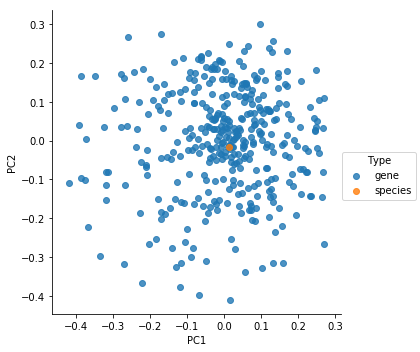

In [35]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Type', fit_reg=False)

In [36]:
ax.fig.savefig('qt.mds.type.pdf', bbox_to_inches='tight')

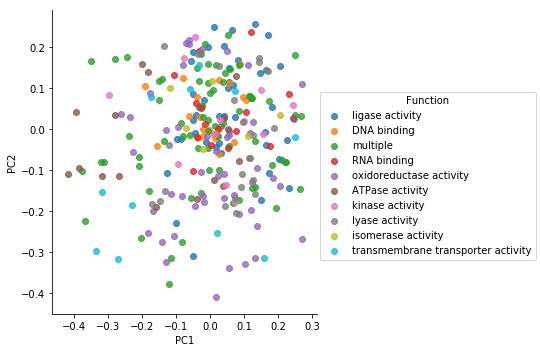

In [37]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Function', fit_reg=False)

In [38]:
ax.fig.savefig('qt.mds.func.pdf', bbox_to_inches='tight')

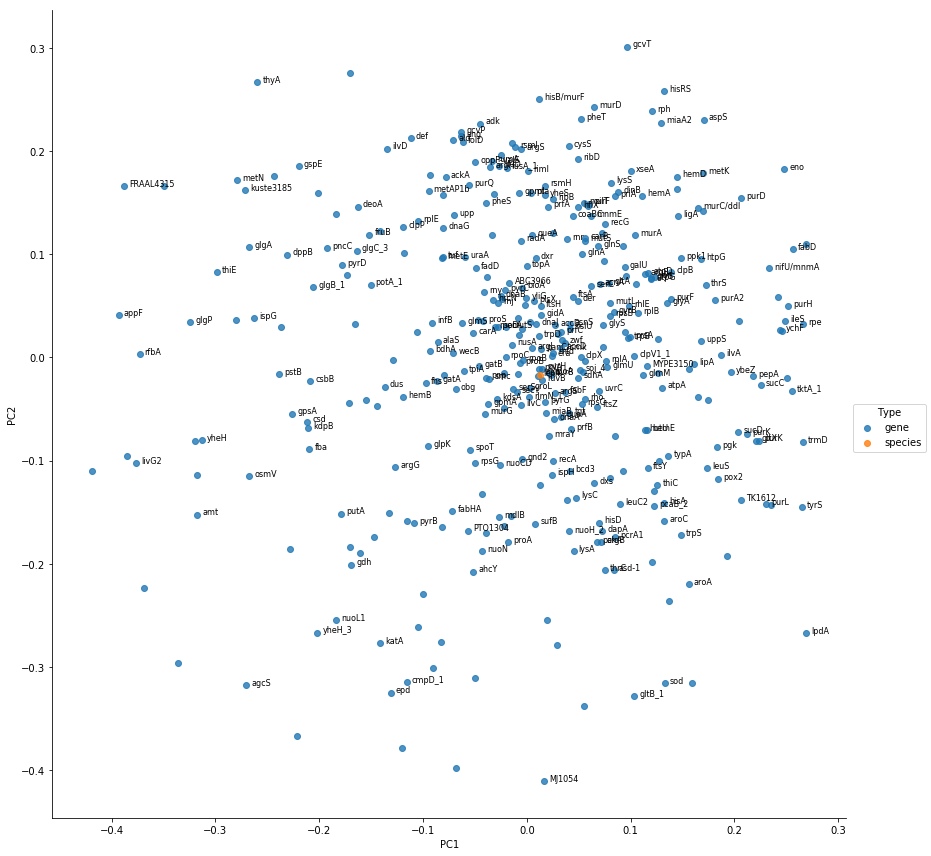

In [39]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Type', fit_reg=False, size=12)
for row in mds.itertuples():
    gene = str(row.Gene)
    if '_' not in gene or len(gene.rsplit('_')[-1]) == 1:
        plt.gca().text(row.PC1 + 0.005, row.PC2, gene, fontsize='8')

In [40]:
ax.fig.savefig('qt.mds.genes.pdf', bbox_to_inches='tight')

Non-metric MDS

In [41]:
nmds = MDS(n_components=axes, metric=False, dissimilarity='precomputed', random_state=42,
           max_iter=3000, eps=1e-12, n_jobs=1)
nmds.fit(qtdm.data)

MDS(dissimilarity='precomputed', eps=1e-12, max_iter=3000, metric=False,
  n_components=5, n_init=4, n_jobs=1, random_state=42, verbose=0)

In [42]:
nmds = pd.DataFrame(data=nmds.embedding_, index=ids, columns=columns)
nmds = pd.concat([nmds, meta[['Type', 'RF', 'Quartet', 'Model', 'Function']]], axis=1, sort=False)
nmds.head()

,PC1,PC2,PC3,PC4,PC5,Type,RF,Quartet,Model,Function
#SampleID,,,,,,,,,,
p0000,0.315933,-0.103392,0.185437,0.020249,0.205743,gene,0.4707,0.7026,LG,ligase activity
p0001,0.141116,0.091177,-0.141593,-0.393269,0.007599,gene,0.5646,0.6587,LG,NaN
p0002,0.239242,0.072856,0.200099,0.279677,-0.164384,gene,0.4646,0.7736,LG,NaN
p0003,0.133483,0.104039,0.289685,0.270617,0.132916,gene,0.3637,0.8805,LG,DNA binding
p0004,-0.139687,0.205213,-0.226970,0.135828,0.271608,gene,0.6127,0.7411,LG,NaN


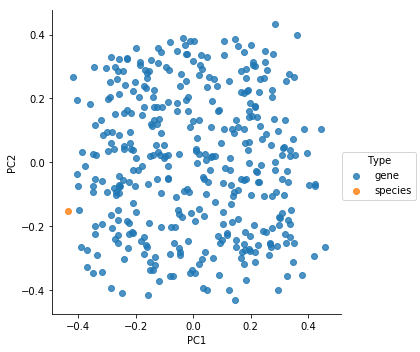

In [43]:
ax = sns.lmplot(data=nmds, x='PC1', y='PC2', hue='Type', fit_reg=False)

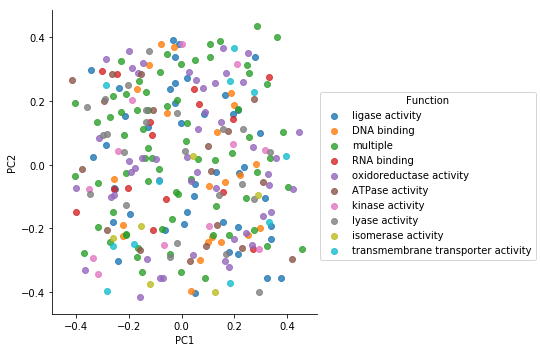

In [44]:
ax = sns.lmplot(data=nmds, x='PC1', y='PC2', hue='Function', fit_reg=False)

### MDS for Robinson–Foulds distance

In [45]:
mds = MDS(n_components=axes, dissimilarity='precomputed', random_state=42,
          max_iter=3000, eps=1e-12, n_jobs=1)
mds.fit(rfdm.data)
mds.stress_

1539.6193212466499

In [46]:
mds = pd.DataFrame(data=mds.embedding_, index=ids, columns=columns)
mds.to_csv('rf.mds.tsv', sep='\t')

In [47]:
with open('rf.mds.coords', 'w') as f:
    for line in make_emp_coods(mds):
        f.write('%s\n' % line)

In [48]:
mds = pd.concat([mds, meta[['Type', 'Gene', 'RF', 'Quartet', 'Model', 'Function']]],
                axis=1, sort=False)

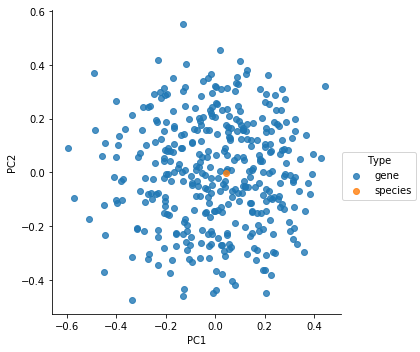

In [49]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Type', fit_reg=False)

In [50]:
ax.fig.savefig('rf.mds.type.pdf', bbox_to_inches='tight')

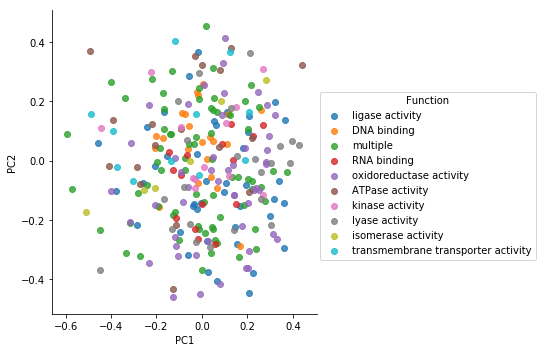

In [51]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Function', fit_reg=False)

In [52]:
ax.fig.savefig('rf.mds.func.pdf', bbox_to_inches='tight')

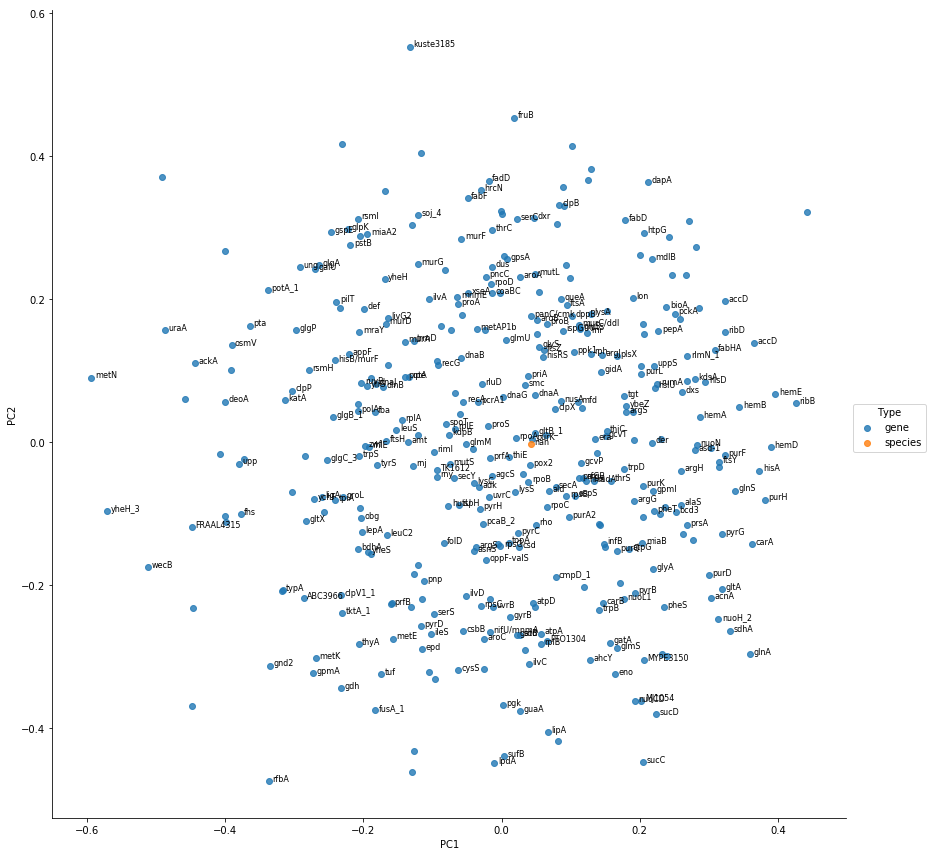

In [53]:
ax = sns.lmplot(data=mds, x='PC1', y='PC2', hue='Type', fit_reg=False, size=12)
for row in mds.itertuples():
    gene = str(row.Gene)
    if '_' not in gene or len(gene.rsplit('_')[-1]) == 1:
        plt.gca().text(row.PC1 + 0.005, row.PC2, gene, fontsize='8')

In [54]:
ax.fig.savefig('rf.mds.genes.pdf', bbox_to_inches='tight')